In [20]:
#Import of packages
import pandas as pd
import palettable
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#import geopandas
#import shapely

import math
import numpy as np
import random
# setup plotting tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.pylab import *
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
import matplotlib.colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import colorConverter as cc
from matplotlib.gridspec import GridSpec as GS
#from util import lexsort_rows


import h5py
import networkx as nx
from matplotlib.patches import Polygon
from pylab import rcParams
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import ImageGrid
import warnings
from numpy.linalg import matrix_power
warnings.filterwarnings('ignore')
%run -i General_Function.py

# Get the data

In [102]:
def Create_B1(edge_list):
    L = len(edge_list)
    N = max(map(max, zip(*edge_list))) + 1
    B1 = np.zeros((N,L))
    for index in range(L):
        edge = edge_list[index]
        B1[edge[0],index] = -1
        B1[edge[1],index] = 1
    return B1

def paths_to_flows(edge_list, traj_nodes):
    flows = []
    for p in traj_nodes:
        f = np.zeros(len(edge_list))
        for index in range(len(p)-1):
            i = p[index]
            j = p[index+1]
            if i > j:
                i,j = j,i
                flow_val = -1
            else:
                flow_val = 1
            f[edge_list.index((i,j))] += flow_val
        flows.append(f)
    return flows

#Generate noisy signal for buyos
def noisy_signal(D,psi_true, alpha):
    
    w,v = np.linalg.eigh(D)
    v_nonzero = v[:, (~np.isclose(w, 0))]
    w_nonzero = w[(~np.isclose(w, 0))]
    k = np.linalg.norm(psi_true, 2)
    noise = np.random.normal(0,k,psi_true.shape[0])/np.sqrt(len(w_nonzero)) #Remove the harmonic components
    noise = ((v_nonzero).dot(np.transpose(v_nonzero))).dot(noise)
    return psi_true +  alpha * noise


def xy_to_long_lattitude(a):
    """
    return longitude and latitude coordinates from x and y 

    input:
    a = [x,y]
    return:
    [long, lat]
    """
    x = a[0]
    y = a[1]
    long = x*180/np.pi
    lat = np.arcsin(y)*180/np.pi
    return [long ,lat]

In [104]:
#Get the Dirac operator, and Gamma
f = h5py.File('dataBuoys.jld2', 'r')
f2 = h5py.File('dataBuoys-coords.jld2', 'r')
edge_list_np = (f['elist'][:] - 1).T
edge_list = [tuple(e) for e in edge_list_np]
B1 = Create_B1(edge_list)
N, L = B1.shape
D = np.block([[np.zeros((N,N)),B1],[B1.transpose(),np.zeros((L,L))]])
Gamma = np.block([[np.identity(N),np.zeros((N,L))],
                  [np.zeros((L,N)), -np.identity(L)]])

#Extract the true signal
traj_nodes = [[f[x][()] - 1 for x in f[ref][()]] for ref in f['TrajectoriesNodes'][:]]
flows = paths_to_flows(edge_list, traj_nodes)
Hexcenters = [[x[0],x[1]] for x in f['HexcentersXY'][:]]
NodeID = [f2[ref][()] for ref in f2['HexToNodeIDs'][:]]
psi_l = np.concatenate((np.zeros(N),sum(flows,0)),0)
psi_gen = psi_l + (D).dot(psi_l)

#The coordinated of the nodes
Pos = {}
G = nx.Graph()
G.add_edges_from(edge_list)
for i in np.arange(G.number_of_nodes()):
    Pos[i]= xy_to_long_lattitude(Hexcenters[i])
df = pd.DataFrame.from_dict(Pos, orient='index', columns=['x', 'y'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'label'}, inplace=True)

# The performance of the IDESP (Figure 7)

In [96]:
alpha = 0.25
psi_true = D.dot(np.linalg.pinv(D)).dot(psi_gen)
psi_true /= np.linalg.norm(psi_true, 2)
psi_tilde = noisy_signal(D,psi_true, alpha)

In [97]:
c_V_True, psi_hat_res_Lap, psi_hat_J_Lap, Error_J_Lap, c_V_J_Lap = IDESP(D, Gamma, psi_true, psi_tilde, signal_predection_Laplacian)
psi_hat_res_DSP, psi_hat_J_DSP, Error_J_DSP, c_V_J_DSP = IDESP(D, Gamma, psi_true, psi_tilde, signal_predection_Dirac)[1:]
psi_hat_res_DESP_L, psi_hat_J_DESP_L, Error_J_DESP_L, c_V_J_DESP_L = IDESP(D, Gamma, psi_true, psi_tilde, signal_predection_Dirac_Equation)[1:]
psi_hat_res_DESP_S, psi_hat_J_DESP_S, Error_J_DESP_S, c_V_J_DESP_S = IDESP(D, Gamma, psi_true, psi_tilde, signal_predection_Dirac_Equation_S)[1:]

<Figure size 640x400 with 0 Axes>

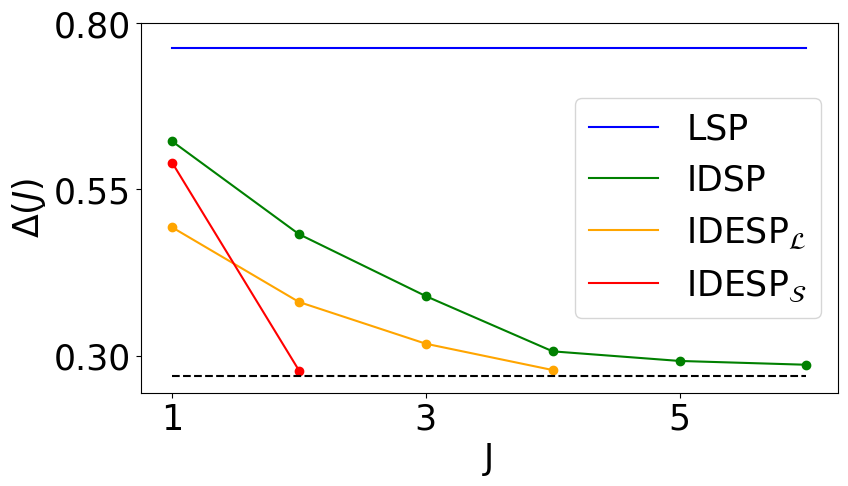

<Figure size 640x400 with 0 Axes>

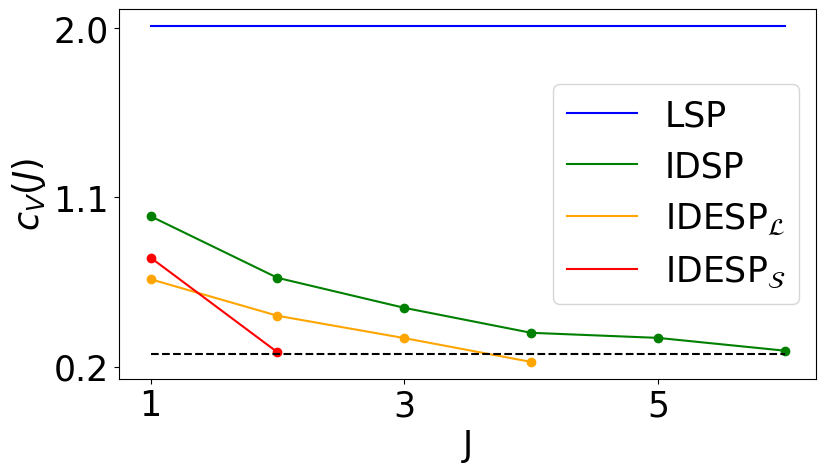

In [100]:
matplotlib.rcParams.update({'font.size': 25})
plt.figure().set_figheight(4)
plt.figure().set_figwidth(9)
n = len(Error_J_DSP)
plt.plot(Error_J_Lap * np.ones(n), label = r"LSP", color = "blue")
plt.plot(Error_J_DSP, label = r"IDSP", color = "green")
plt.plot(Error_J_DESP_L, label = r"IDESP$_\mathcal{L}$", color = "orange")
plt.plot(Error_J_DESP_S, label = r"IDESP$_\mathcal{S}$", color = "red")
plt.plot(np.ones(n) * c_V_True, color = "black", linestyle='dashed')

plt.scatter(range(len(Error_J_DSP)), Error_J_DSP, color = "green", )
plt.scatter(range(len(Error_J_DESP_L)), Error_J_DESP_L, color = "orange")
plt.scatter(range(len(Error_J_DESP_S)), Error_J_DESP_S, color = "red")
plt.xticks([0,2,4],[1,3,5]) 
plt.yticks([0.3, 0.55, 0.8])
plt.ylabel(r'$\Delta(J)$')
plt.xlabel('J')
plt.legend(loc="right")
plt.show()



plt.figure().set_figheight(4)
plt.figure().set_figwidth(9)

plt.plot(c_V_J_Lap * np.ones(n), label = r"LSP", color = "blue")
plt.plot(c_V_J_DSP[:-1], label = r"IDSP", color = "green")
plt.plot(c_V_J_DESP_L[:-1], label = r"IDESP$_\mathcal{L}$", color = "orange")
plt.plot(c_V_J_DESP_S[:-1], label = r"IDESP$_\mathcal{S}$", color = "red")
plt.plot(np.ones(n) * c_V_True, color = "black", linestyle='dashed')

plt.scatter(range(len(c_V_J_DSP)-1), c_V_J_DSP[:-1], color = "green", )
plt.scatter(range(len(c_V_J_DESP_L)-1), c_V_J_DESP_L[:-1], color = "orange")
plt.scatter(range(len(c_V_J_DESP_S)-1), c_V_J_DESP_S[:-1], color = "red")
plt.xticks([0,2,4],[1,3,5]) 
plt.yticks([0.2,1.1 ,2.0])
plt.ylabel(r'$c_V(J)$')
#plt.ylim(0.0,1.7)
plt.xlabel('J')
plt.legend(loc="right")
plt.show()

# Visualization of IDESP (Figure 6)

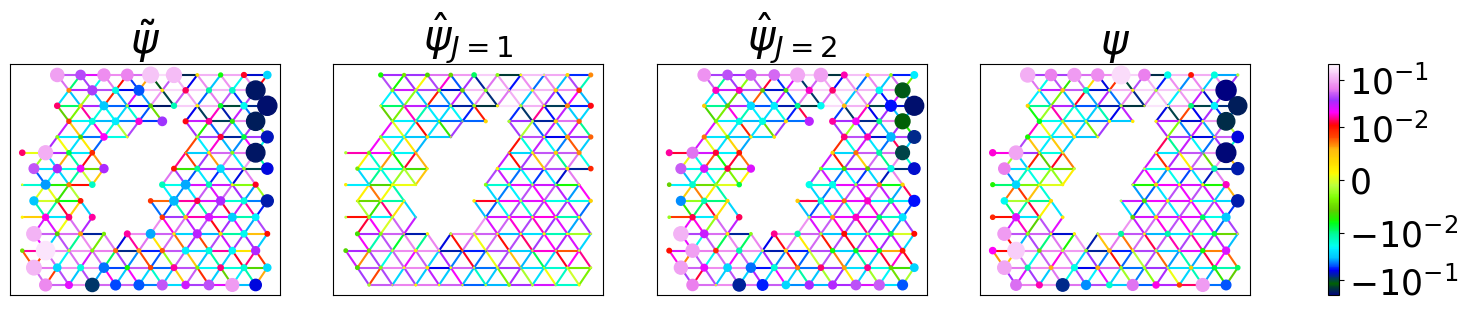

In [103]:
length_j = len(psi_hat_J_DESP_S) + 2
signals = [psi_tilde] + psi_hat_J_DESP_S + [psi_true]
norm = SymLogNorm(linthresh=0.01,
    vmin= -np.max(np.abs(signals)), 
    vmax= np.max(np.abs(signals)),
    base=10
)
colormap = plt.cm.gist_ncar
color_maps = []
for signal in signals:
    color_maps.append([colormap(norm(value)) for value in signal])
    
Titles = [r"$\tilde{\psi}$", r"$\hat{\psi}_{J = 1}$", r"$\hat{\psi}_{J=2}$", r"$\psi$"]
fig, axes = plt.subplots(nrows= 1, ncols= length_j, figsize=(20,3))

for i, ax in enumerate(axes.flat):
    for j in range(len(edge_list)):
        edge = edge_list[j]
        x1,y1 = xy_to_long_lattitude(Hexcenters[edge_list[j][0]])
        x2,y2 = xy_to_long_lattitude(Hexcenters[edge_list[j][1]])
        ax.plot([x1,x2], [y1,y2], color = color_maps[i][N + j] , zorder = 1)
    ax.scatter(df['x'], df['y'], s = np.abs(signals[i][:N]) * 1000, c = color_maps[i][:N], zorder = 2)
    ax.set_title(Titles[i])
    ax.set_xticks([])
    ax.set_yticks([])

sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes)
plt.show()